In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [22]:
dataset = read_data('/home/deepstation/PRMLlab/technicakidz/Data/actitracker_.txt')
#dataset = dataset.replace("\t",",",regex=True)#.replace(';',',')
dataset.shape

(104583, 6)

In [23]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953


In [24]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

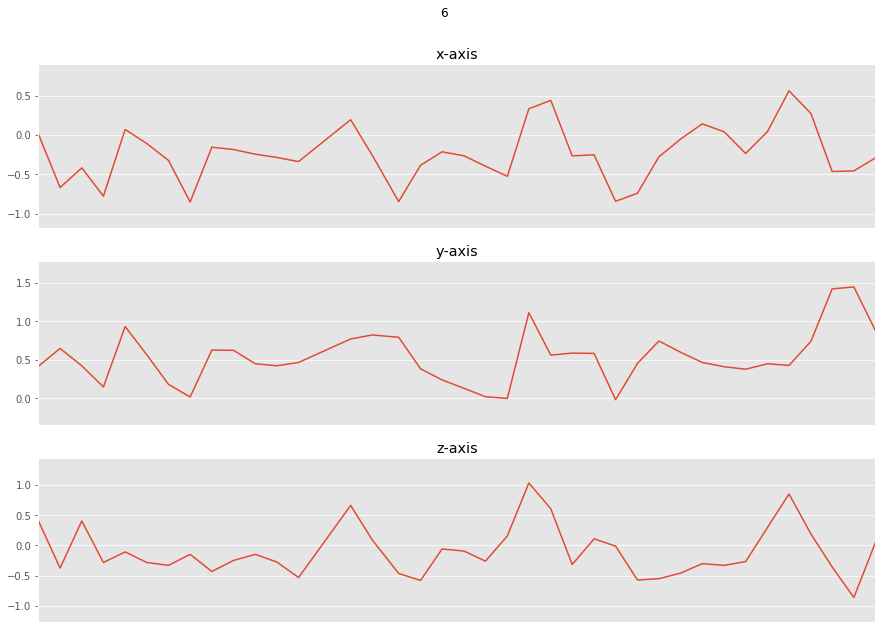

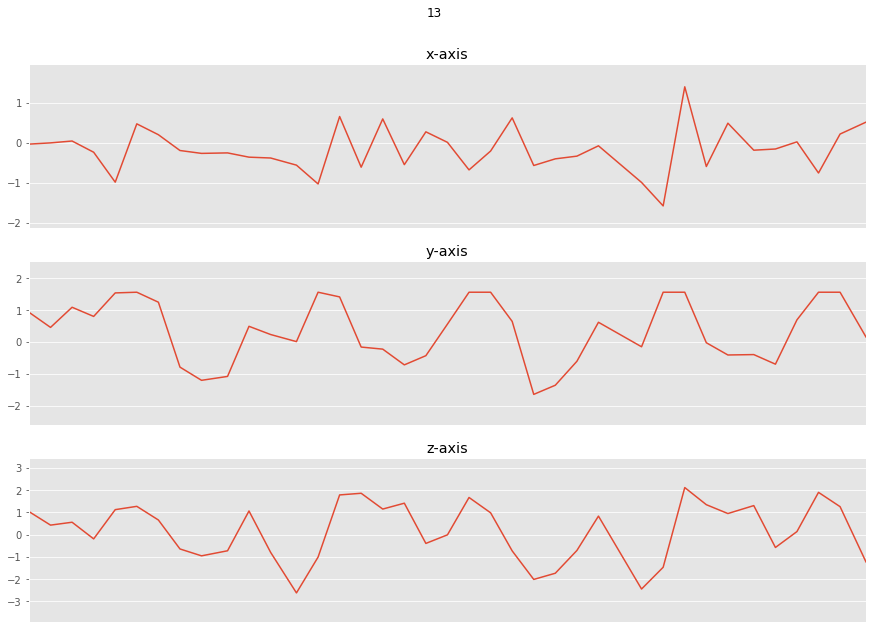

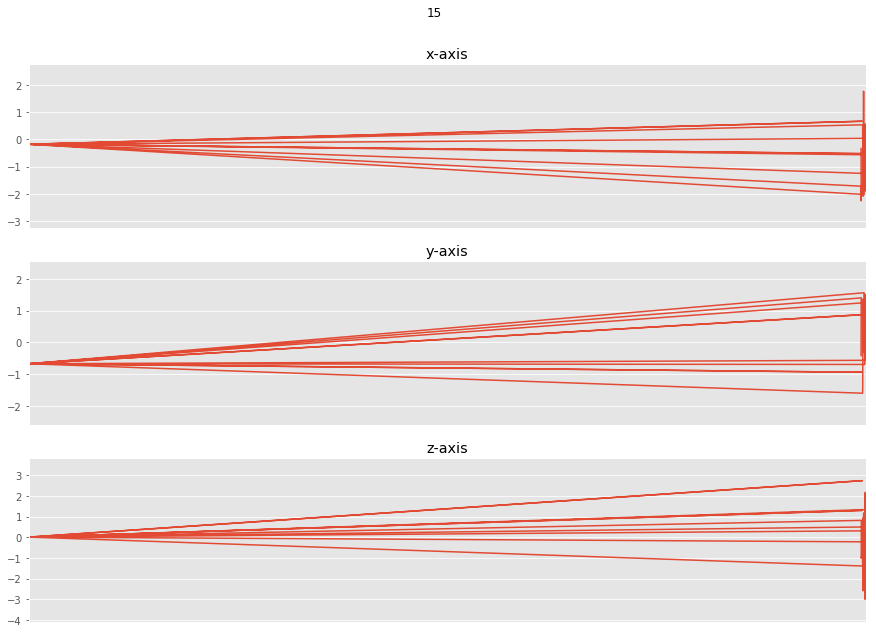

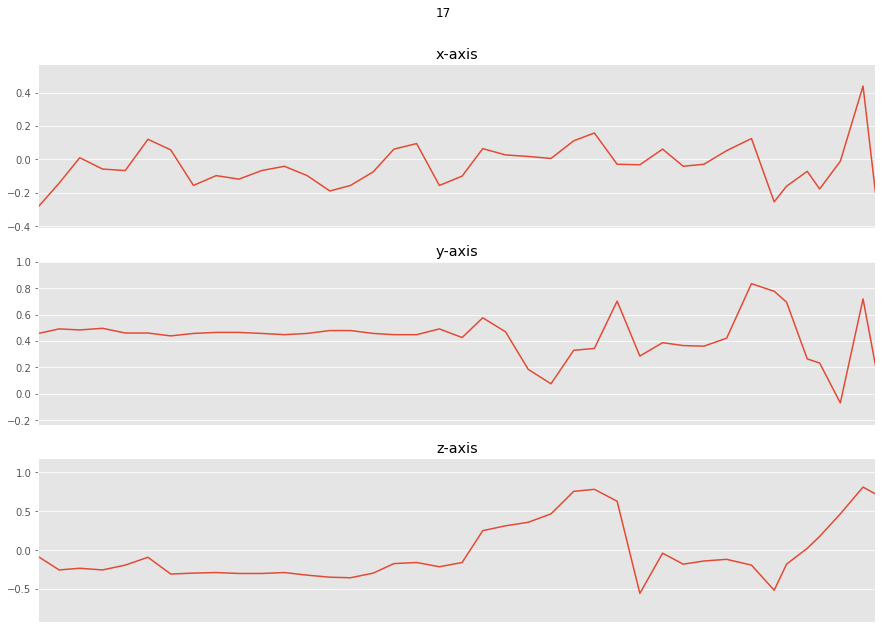

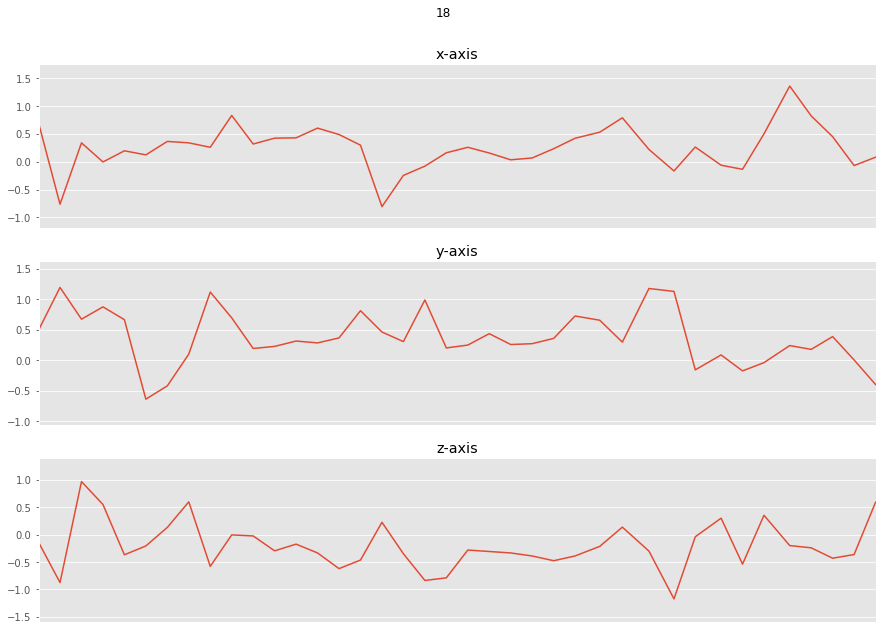

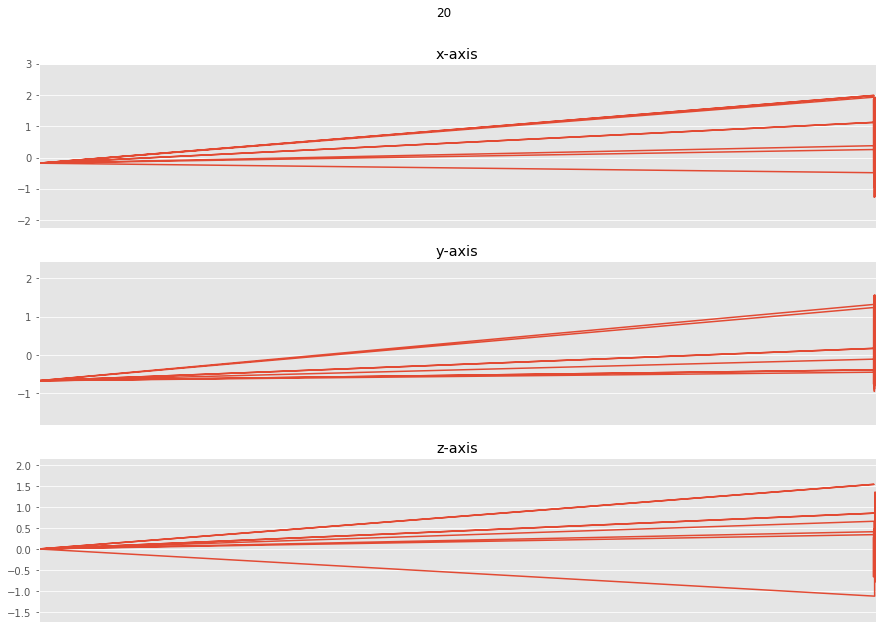

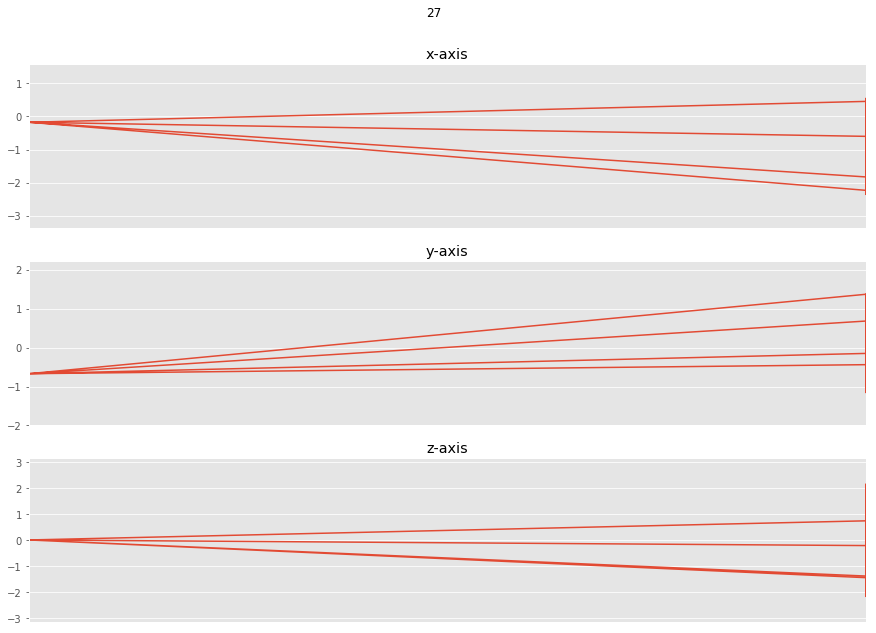

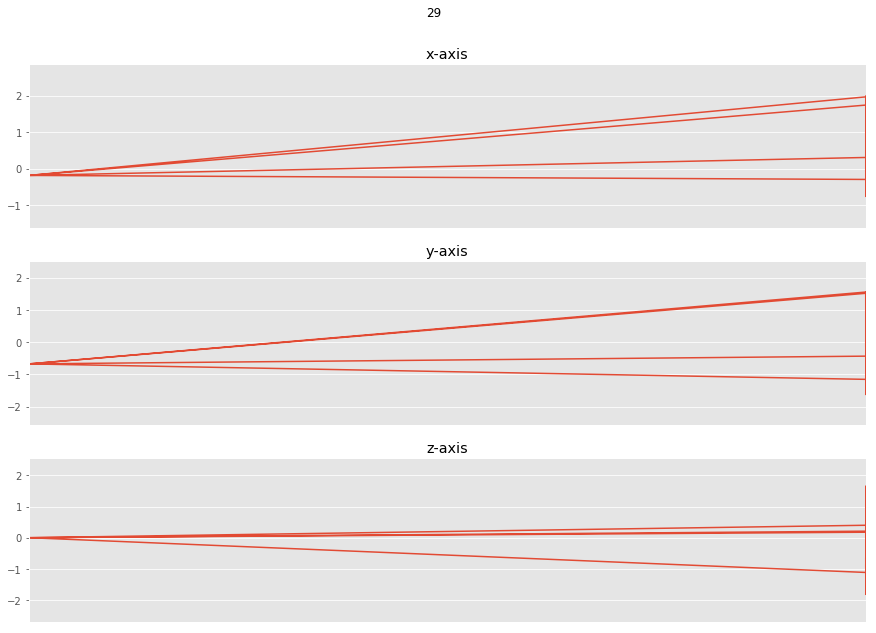

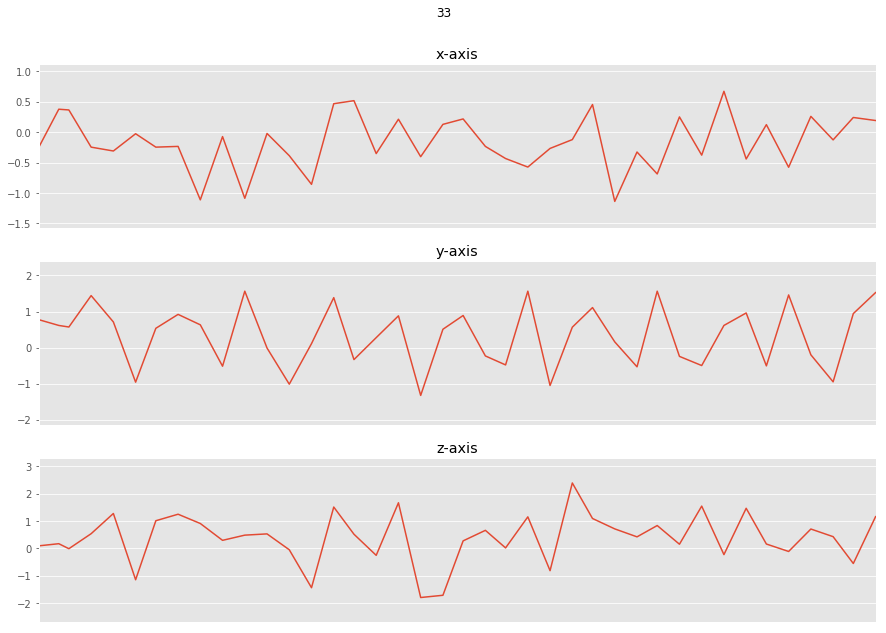

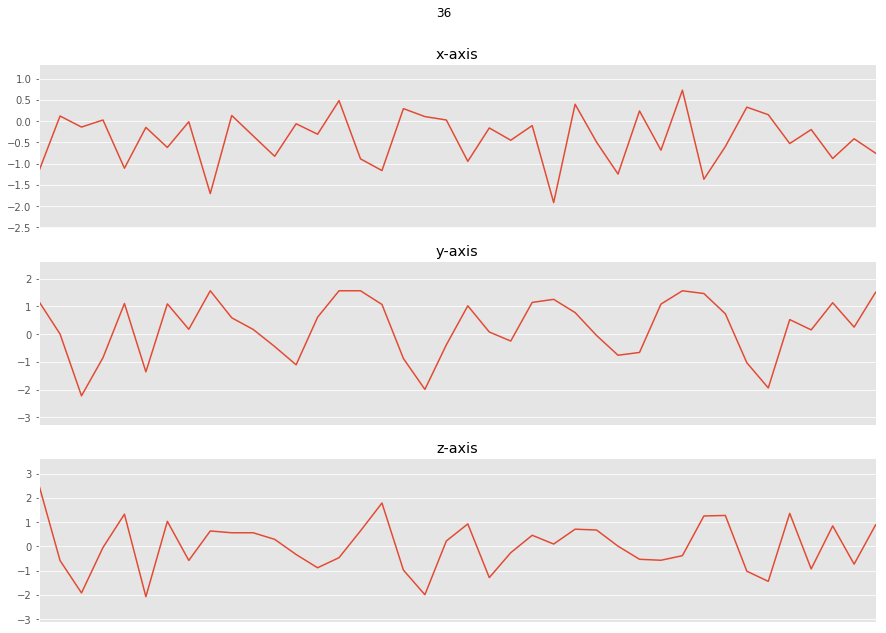

In [25]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [26]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [27]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_xj = reshaped_segments[train_test_split]
train_yj = labels[train_test_split]
test_xj = reshaped_segments[~train_test_split]
test_yj = labels[~train_test_split]

In [28]:
#saved data
np.save('train_xj.npy',train_xj)
np.save('train_yj.npy',train_yj)
np.save('test_xj.npy',test_xj)
np.save('test_yj.npy',test_yj)

In [29]:
import numpy as np
train_xj = np.load('train_xj.npy')
train_yj = np.load('train_yj.npy')
test_xj = np.load('test_xj.npy')
test_yj = np.load('test_yj.npy')

In [35]:
#jogging label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))

Epoch:  0  Training Loss:  1064.25  Training Accuracy:  0.116322
Epoch:  1  Training Loss:  696.441  Training Accuracy:  0.138246
Epoch:  2  Training Loss:  621.116  Training Accuracy:  0.174178
Epoch:  3  Training Loss:  533.131  Training Accuracy:  0.214982
Epoch:  4  Training Loss:  447.337  Training Accuracy:  0.239951
Epoch:  5  Training Loss:  367.046  Training Accuracy:  0.26553
Epoch:  6  Training Loss:  295.144  Training Accuracy:  0.315469
Epoch:  7  Training Loss:  235.121  Training Accuracy:  0.373325
Epoch:  8  Training Loss:  190.771  Training Accuracy:  0.423264
Epoch:  9  Training Loss:  160.438  Training Accuracy:  0.455542
Epoch:  10  Training Loss:  140.491  Training Accuracy:  0.489647
Epoch:  11  Training Loss:  127.038  Training Accuracy:  0.511571
Epoch:  12  Training Loss:  117.731  Training Accuracy:  0.532278
Epoch:  13  Training Loss:  110.889  Training Accuracy:  0.551157
Epoch:  14  Training Loss:  105.67  Training Accuracy:  0.564555
Epoch:  15  Training L

Epoch:  125  Training Loss:  35.1977  Training Accuracy:  0.967722
Epoch:  126  Training Loss:  34.9572  Training Accuracy:  0.967722
Epoch:  127  Training Loss:  34.7234  Training Accuracy:  0.96894
Epoch:  128  Training Loss:  34.4972  Training Accuracy:  0.969549
Epoch:  129  Training Loss:  34.2651  Training Accuracy:  0.969549
Epoch:  130  Training Loss:  34.0359  Training Accuracy:  0.969549
Epoch:  131  Training Loss:  33.8167  Training Accuracy:  0.970158
Epoch:  132  Training Loss:  33.5907  Training Accuracy:  0.970159
Epoch:  133  Training Loss:  33.3719  Training Accuracy:  0.970158
Epoch:  134  Training Loss:  33.1505  Training Accuracy:  0.970159
Epoch:  135  Training Loss:  32.9364  Training Accuracy:  0.970158
Epoch:  136  Training Loss:  32.718  Training Accuracy:  0.970767
Epoch:  137  Training Loss:  32.5085  Training Accuracy:  0.971376
Epoch:  138  Training Loss:  32.2948  Training Accuracy:  0.971376
Epoch:  139  Training Loss:  32.0873  Training Accuracy:  0.9719

Epoch:  248  Training Loss:  16.7966  Training Accuracy:  0.989647
Epoch:  249  Training Loss:  16.7059  Training Accuracy:  0.989647
Epoch:  250  Training Loss:  16.6165  Training Accuracy:  0.990256
Epoch:  251  Training Loss:  16.5292  Training Accuracy:  0.990256
Epoch:  252  Training Loss:  16.4422  Training Accuracy:  0.990256
Epoch:  253  Training Loss:  16.3557  Training Accuracy:  0.990256
Epoch:  254  Training Loss:  16.27  Training Accuracy:  0.990256
Epoch:  255  Training Loss:  16.1846  Training Accuracy:  0.990256
Epoch:  256  Training Loss:  16.1009  Training Accuracy:  0.990256
Epoch:  257  Training Loss:  16.0157  Training Accuracy:  0.990256
Epoch:  258  Training Loss:  15.9331  Training Accuracy:  0.990256
Epoch:  259  Training Loss:  15.8484  Training Accuracy:  0.990256
Epoch:  260  Training Loss:  15.7662  Training Accuracy:  0.990256
Epoch:  261  Training Loss:  15.6833  Training Accuracy:  0.990256
Epoch:  262  Training Loss:  15.6032  Training Accuracy:  0.9902

Epoch:  371  Training Loss:  9.16611  Training Accuracy:  0.995737
Epoch:  372  Training Loss:  9.12444  Training Accuracy:  0.995737
Epoch:  373  Training Loss:  9.08537  Training Accuracy:  0.995737
Epoch:  374  Training Loss:  9.04318  Training Accuracy:  0.995737
Epoch:  375  Training Loss:  9.00236  Training Accuracy:  0.995737
Epoch:  376  Training Loss:  8.96347  Training Accuracy:  0.995737
Epoch:  377  Training Loss:  8.92301  Training Accuracy:  0.995737
Epoch:  378  Training Loss:  8.88279  Training Accuracy:  0.995737
Epoch:  379  Training Loss:  8.84365  Training Accuracy:  0.995737
Epoch:  380  Training Loss:  8.80501  Training Accuracy:  0.995737
Epoch:  381  Training Loss:  8.76742  Training Accuracy:  0.995737
Epoch:  382  Training Loss:  8.72766  Training Accuracy:  0.995737
Epoch:  383  Training Loss:  8.68894  Training Accuracy:  0.995737
Epoch:  384  Training Loss:  8.6509  Training Accuracy:  0.995737
Epoch:  385  Training Loss:  8.6122  Training Accuracy:  0.9957

Epoch:  494  Training Loss:  5.52616  Training Accuracy:  0.996955
Epoch:  495  Training Loss:  5.50545  Training Accuracy:  0.996955
Epoch:  496  Training Loss:  5.48548  Training Accuracy:  0.996955
Epoch:  497  Training Loss:  5.46549  Training Accuracy:  0.996955
Epoch:  498  Training Loss:  5.44504  Training Accuracy:  0.996955
Epoch:  499  Training Loss:  5.42517  Training Accuracy:  0.996955
Epoch:  500  Training Loss:  5.40622  Training Accuracy:  0.996955
Epoch:  501  Training Loss:  5.38612  Training Accuracy:  0.996955
Epoch:  502  Training Loss:  5.36674  Training Accuracy:  0.996955
Epoch:  503  Training Loss:  5.34757  Training Accuracy:  0.996955
Epoch:  504  Training Loss:  5.328  Training Accuracy:  0.996955
Epoch:  505  Training Loss:  5.3088  Training Accuracy:  0.996955
Epoch:  506  Training Loss:  5.29048  Training Accuracy:  0.996955
Epoch:  507  Training Loss:  5.27059  Training Accuracy:  0.996955
Epoch:  508  Training Loss:  5.25181  Training Accuracy:  0.99695

Epoch:  617  Training Loss:  3.6871  Training Accuracy:  0.998173
Epoch:  618  Training Loss:  3.67613  Training Accuracy:  0.998173
Epoch:  619  Training Loss:  3.66571  Training Accuracy:  0.998173
Epoch:  620  Training Loss:  3.65495  Training Accuracy:  0.998173
Epoch:  621  Training Loss:  3.64449  Training Accuracy:  0.998173
Epoch:  622  Training Loss:  3.63392  Training Accuracy:  0.998173
Epoch:  623  Training Loss:  3.62331  Training Accuracy:  0.998173
Epoch:  624  Training Loss:  3.6131  Training Accuracy:  0.998173
Epoch:  625  Training Loss:  3.60272  Training Accuracy:  0.998173
Epoch:  626  Training Loss:  3.59247  Training Accuracy:  0.998173
Epoch:  627  Training Loss:  3.5819  Training Accuracy:  0.998173
Epoch:  628  Training Loss:  3.5721  Training Accuracy:  0.998173
Epoch:  629  Training Loss:  3.56175  Training Accuracy:  0.998173
Epoch:  630  Training Loss:  3.55164  Training Accuracy:  0.998173
Epoch:  631  Training Loss:  3.54149  Training Accuracy:  0.998173

Epoch:  740  Training Loss:  2.67961  Training Accuracy:  0.998173
Epoch:  741  Training Loss:  2.67345  Training Accuracy:  0.998173
Epoch:  742  Training Loss:  2.66749  Training Accuracy:  0.998173
Epoch:  743  Training Loss:  2.66124  Training Accuracy:  0.998173
Epoch:  744  Training Loss:  2.6551  Training Accuracy:  0.998173
Epoch:  745  Training Loss:  2.64918  Training Accuracy:  0.998173
Epoch:  746  Training Loss:  2.64295  Training Accuracy:  0.998173
Epoch:  747  Training Loss:  2.63679  Training Accuracy:  0.998173
Epoch:  748  Training Loss:  2.63096  Training Accuracy:  0.998173
Epoch:  749  Training Loss:  2.62498  Training Accuracy:  0.998173
Epoch:  750  Training Loss:  2.61911  Training Accuracy:  0.998173
Epoch:  751  Training Loss:  2.61305  Training Accuracy:  0.998173
Epoch:  752  Training Loss:  2.60723  Training Accuracy:  0.998173
Epoch:  753  Training Loss:  2.60119  Training Accuracy:  0.998173
Epoch:  754  Training Loss:  2.59541  Training Accuracy:  0.998

Epoch:  863  Training Loss:  2.07603  Training Accuracy:  0.998173
Epoch:  864  Training Loss:  2.07207  Training Accuracy:  0.998173
Epoch:  865  Training Loss:  2.06834  Training Accuracy:  0.998173
Epoch:  866  Training Loss:  2.06439  Training Accuracy:  0.998173
Epoch:  867  Training Loss:  2.06063  Training Accuracy:  0.998173
Epoch:  868  Training Loss:  2.05672  Training Accuracy:  0.998173
Epoch:  869  Training Loss:  2.05303  Training Accuracy:  0.998173
Epoch:  870  Training Loss:  2.04913  Training Accuracy:  0.998173
Epoch:  871  Training Loss:  2.04548  Training Accuracy:  0.998173
Epoch:  872  Training Loss:  2.04163  Training Accuracy:  0.998173
Epoch:  873  Training Loss:  2.03791  Training Accuracy:  0.998173
Epoch:  874  Training Loss:  2.0341  Training Accuracy:  0.998173
Epoch:  875  Training Loss:  2.03046  Training Accuracy:  0.998173
Epoch:  876  Training Loss:  2.02672  Training Accuracy:  0.998173
Epoch:  877  Training Loss:  2.02302  Training Accuracy:  0.998

Epoch:  986  Training Loss:  1.68405  Training Accuracy:  0.998173
Epoch:  987  Training Loss:  1.68148  Training Accuracy:  0.998173
Epoch:  988  Training Loss:  1.67881  Training Accuracy:  0.998173
Epoch:  989  Training Loss:  1.67626  Training Accuracy:  0.998173
Epoch:  990  Training Loss:  1.67364  Training Accuracy:  0.998173
Epoch:  991  Training Loss:  1.67105  Training Accuracy:  0.998173
Epoch:  992  Training Loss:  1.66841  Training Accuracy:  0.998173
Epoch:  993  Training Loss:  1.66588  Training Accuracy:  0.998173
Epoch:  994  Training Loss:  1.6633  Training Accuracy:  0.998173
Epoch:  995  Training Loss:  1.66074  Training Accuracy:  0.998173
Epoch:  996  Training Loss:  1.65819  Training Accuracy:  0.998173
Epoch:  997  Training Loss:  1.65562  Training Accuracy:  0.998173
Epoch:  998  Training Loss:  1.65314  Training Accuracy:  0.998173
Epoch:  999  Training Loss:  1.65049  Training Accuracy:  0.998173
Epoch:  1000  Training Loss:  1.64804  Training Accuracy:  0.99

Epoch:  1107  Training Loss:  1.41361  Training Accuracy:  0.998173
Epoch:  1108  Training Loss:  1.41163  Training Accuracy:  0.998173
Epoch:  1109  Training Loss:  1.40975  Training Accuracy:  0.998173
Epoch:  1110  Training Loss:  1.40787  Training Accuracy:  0.998173
Epoch:  1111  Training Loss:  1.406  Training Accuracy:  0.998173
Epoch:  1112  Training Loss:  1.40408  Training Accuracy:  0.998173
Epoch:  1113  Training Loss:  1.40224  Training Accuracy:  0.998173
Epoch:  1114  Training Loss:  1.4003  Training Accuracy:  0.998173
Epoch:  1115  Training Loss:  1.39853  Training Accuracy:  0.998173
Epoch:  1116  Training Loss:  1.39661  Training Accuracy:  0.998173
Epoch:  1117  Training Loss:  1.39479  Training Accuracy:  0.998173
Epoch:  1118  Training Loss:  1.39292  Training Accuracy:  0.998173
Epoch:  1119  Training Loss:  1.3911  Training Accuracy:  0.998173
Epoch:  1120  Training Loss:  1.38921  Training Accuracy:  0.998173
Epoch:  1121  Training Loss:  1.38743  Training Accu

Epoch:  1228  Training Loss:  1.21362  Training Accuracy:  0.998173
Epoch:  1229  Training Loss:  1.21219  Training Accuracy:  0.998173
Epoch:  1230  Training Loss:  1.21074  Training Accuracy:  0.998173
Epoch:  1231  Training Loss:  1.20935  Training Accuracy:  0.998173
Epoch:  1232  Training Loss:  1.20794  Training Accuracy:  0.998173
Epoch:  1233  Training Loss:  1.2065  Training Accuracy:  0.998173
Epoch:  1234  Training Loss:  1.20511  Training Accuracy:  0.998173
Epoch:  1235  Training Loss:  1.20369  Training Accuracy:  0.998173
Epoch:  1236  Training Loss:  1.20225  Training Accuracy:  0.998173
Epoch:  1237  Training Loss:  1.2009  Training Accuracy:  0.998173
Epoch:  1238  Training Loss:  1.19943  Training Accuracy:  0.998173
Epoch:  1239  Training Loss:  1.19805  Training Accuracy:  0.998173
Epoch:  1240  Training Loss:  1.19664  Training Accuracy:  0.998173
Epoch:  1241  Training Loss:  1.19522  Training Accuracy:  0.998173
Epoch:  1242  Training Loss:  1.19381  Training Ac

Epoch:  1349  Training Loss:  1.0605  Training Accuracy:  0.998782
Epoch:  1350  Training Loss:  1.0594  Training Accuracy:  0.998782
Epoch:  1351  Training Loss:  1.05827  Training Accuracy:  0.998782
Epoch:  1352  Training Loss:  1.05721  Training Accuracy:  0.998782
Epoch:  1353  Training Loss:  1.05608  Training Accuracy:  0.998782
Epoch:  1354  Training Loss:  1.05499  Training Accuracy:  0.998782
Epoch:  1355  Training Loss:  1.05387  Training Accuracy:  0.998782
Epoch:  1356  Training Loss:  1.0528  Training Accuracy:  0.998782
Epoch:  1357  Training Loss:  1.05166  Training Accuracy:  0.998782
Epoch:  1358  Training Loss:  1.05056  Training Accuracy:  0.998782
Epoch:  1359  Training Loss:  1.04948  Training Accuracy:  0.998782
Epoch:  1360  Training Loss:  1.04842  Training Accuracy:  0.998782
Epoch:  1361  Training Loss:  1.04733  Training Accuracy:  0.998782
Epoch:  1362  Training Loss:  1.04623  Training Accuracy:  0.998782
Epoch:  1363  Training Loss:  1.04514  Training Acc

Epoch:  1469  Training Loss:  0.941113  Training Accuracy:  0.998782
Epoch:  1470  Training Loss:  0.940225  Training Accuracy:  0.998782
Epoch:  1471  Training Loss:  0.939364  Training Accuracy:  0.998782
Epoch:  1472  Training Loss:  0.938445  Training Accuracy:  0.998782
Epoch:  1473  Training Loss:  0.93759  Training Accuracy:  0.998782
Epoch:  1474  Training Loss:  0.936683  Training Accuracy:  0.998782
Epoch:  1475  Training Loss:  0.935812  Training Accuracy:  0.998782
Epoch:  1476  Training Loss:  0.934924  Training Accuracy:  0.998782
Epoch:  1477  Training Loss:  0.934059  Training Accuracy:  0.998782
Epoch:  1478  Training Loss:  0.933147  Training Accuracy:  0.998782
Epoch:  1479  Training Loss:  0.932319  Training Accuracy:  0.998782
Epoch:  1480  Training Loss:  0.931444  Training Accuracy:  0.998782
Epoch:  1481  Training Loss:  0.930556  Training Accuracy:  0.998782
Epoch:  1482  Training Loss:  0.929676  Training Accuracy:  0.998782
Epoch:  1483  Training Loss:  0.928

Epoch:  1588  Training Loss:  0.845034  Training Accuracy:  0.998782
Epoch:  1589  Training Loss:  0.844274  Training Accuracy:  0.998782
Epoch:  1590  Training Loss:  0.843548  Training Accuracy:  0.998782
Epoch:  1591  Training Loss:  0.84284  Training Accuracy:  0.998782
Epoch:  1592  Training Loss:  0.842118  Training Accuracy:  0.998782
Epoch:  1593  Training Loss:  0.841382  Training Accuracy:  0.998782
Epoch:  1594  Training Loss:  0.840648  Training Accuracy:  0.998782
Epoch:  1595  Training Loss:  0.839946  Training Accuracy:  0.998782
Epoch:  1596  Training Loss:  0.839204  Training Accuracy:  0.998782
Epoch:  1597  Training Loss:  0.838474  Training Accuracy:  0.998782
Epoch:  1598  Training Loss:  0.83778  Training Accuracy:  0.998782
Epoch:  1599  Training Loss:  0.837089  Training Accuracy:  0.998782
Epoch:  1600  Training Loss:  0.836353  Training Accuracy:  0.998782
Epoch:  1601  Training Loss:  0.83565  Training Accuracy:  0.998782
Epoch:  1602  Training Loss:  0.83494

Epoch:  1707  Training Loss:  0.76579  Training Accuracy:  0.998782
Epoch:  1708  Training Loss:  0.765167  Training Accuracy:  0.998782
Epoch:  1709  Training Loss:  0.764584  Training Accuracy:  0.998782
Epoch:  1710  Training Loss:  0.763966  Training Accuracy:  0.998782
Epoch:  1711  Training Loss:  0.763361  Training Accuracy:  0.998782
Epoch:  1712  Training Loss:  0.762769  Training Accuracy:  0.998782
Epoch:  1713  Training Loss:  0.762153  Training Accuracy:  0.998782
Epoch:  1714  Training Loss:  0.761568  Training Accuracy:  0.998782
Epoch:  1715  Training Loss:  0.760959  Training Accuracy:  0.998782
Epoch:  1716  Training Loss:  0.760354  Training Accuracy:  0.998782
Epoch:  1717  Training Loss:  0.759748  Training Accuracy:  0.998782
Epoch:  1718  Training Loss:  0.759138  Training Accuracy:  0.998782
Epoch:  1719  Training Loss:  0.758551  Training Accuracy:  0.998782
Epoch:  1720  Training Loss:  0.757951  Training Accuracy:  0.998782
Epoch:  1721  Training Loss:  0.757

Epoch:  1826  Training Loss:  0.699401  Training Accuracy:  0.998782
Epoch:  1827  Training Loss:  0.698906  Training Accuracy:  0.998782
Epoch:  1828  Training Loss:  0.698389  Training Accuracy:  0.998782
Epoch:  1829  Training Loss:  0.697861  Training Accuracy:  0.998782
Epoch:  1830  Training Loss:  0.697362  Training Accuracy:  0.998782
Epoch:  1831  Training Loss:  0.696854  Training Accuracy:  0.998782
Epoch:  1832  Training Loss:  0.696333  Training Accuracy:  0.998782
Epoch:  1833  Training Loss:  0.695837  Training Accuracy:  0.998782
Epoch:  1834  Training Loss:  0.69533  Training Accuracy:  0.998782
Epoch:  1835  Training Loss:  0.694823  Training Accuracy:  0.998782
Epoch:  1836  Training Loss:  0.694329  Training Accuracy:  0.998782
Epoch:  1837  Training Loss:  0.693816  Training Accuracy:  0.998782
Epoch:  1838  Training Loss:  0.693309  Training Accuracy:  0.998782
Epoch:  1839  Training Loss:  0.692813  Training Accuracy:  0.998782
Epoch:  1840  Training Loss:  0.692

Epoch:  1945  Training Loss:  0.643224  Training Accuracy:  0.998782
Epoch:  1946  Training Loss:  0.642779  Training Accuracy:  0.998782
Epoch:  1947  Training Loss:  0.642348  Training Accuracy:  0.998782
Epoch:  1948  Training Loss:  0.641916  Training Accuracy:  0.998782
Epoch:  1949  Training Loss:  0.641469  Training Accuracy:  0.998782
Epoch:  1950  Training Loss:  0.641047  Training Accuracy:  0.998782
Epoch:  1951  Training Loss:  0.64061  Training Accuracy:  0.998782
Epoch:  1952  Training Loss:  0.640166  Training Accuracy:  0.998782
Epoch:  1953  Training Loss:  0.639744  Training Accuracy:  0.998782
Epoch:  1954  Training Loss:  0.63932  Training Accuracy:  0.998782
Epoch:  1955  Training Loss:  0.638879  Training Accuracy:  0.998782
Epoch:  1956  Training Loss:  0.638448  Training Accuracy:  0.998782
Epoch:  1957  Training Loss:  0.638024  Training Accuracy:  0.998782
Epoch:  1958  Training Loss:  0.63758  Training Accuracy:  0.998782
Epoch:  1959  Training Loss:  0.63716

In [32]:
batch_x.shape

(16, 1, 90, 3)

In [33]:
batch_y.shape

(16, 10)

In [ ]:
#jogging label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))

Epoch:  0  Training Loss:  4.47832  Training Accuracy:  0.119367
Epoch:  1  Training Loss:  3.68246  Training Accuracy:  0.12363
Epoch:  2  Training Loss:  3.2023  Training Accuracy:  0.144336
Epoch:  3  Training Loss:  2.89162  Training Accuracy:  0.186967
Epoch:  4  Training Loss:  2.68267  Training Accuracy:  0.257613
Epoch:  5  Training Loss:  2.54458  Training Accuracy:  0.322777
Epoch:  6  Training Loss:  2.45767  Training Accuracy:  0.37637
Epoch:  7  Training Loss:  2.40172  Training Accuracy:  0.414738
Epoch:  8  Training Loss:  2.36573  Training Accuracy:  0.448234
Epoch:  9  Training Loss:  2.34059  Training Accuracy:  0.482948
Epoch:  10  Training Loss:  2.32284  Training Accuracy:  0.521924
Epoch:  11  Training Loss:  2.30761  Training Accuracy:  0.543849
Epoch:  12  Training Loss:  2.29382  Training Accuracy:  0.573691
Epoch:  13  Training Loss:  2.2797  Training Accuracy:  0.599269
Epoch:  14  Training Loss:  2.26685  Training Accuracy:  0.619976
Epoch:  15  Training Los

Epoch:  125  Training Loss:  1.01776  Training Accuracy:  0.96894
Epoch:  126  Training Loss:  1.01247  Training Accuracy:  0.969549
Epoch:  127  Training Loss:  1.00751  Training Accuracy:  0.970158
Epoch:  128  Training Loss:  1.0024  Training Accuracy:  0.970767
Epoch:  129  Training Loss:  0.997474  Training Accuracy:  0.971985
Epoch:  130  Training Loss:  0.992539  Training Accuracy:  0.971985
Epoch:  131  Training Loss:  0.98785  Training Accuracy:  0.972594
Epoch:  132  Training Loss:  0.983241  Training Accuracy:  0.973203
Epoch:  133  Training Loss:  0.9789  Training Accuracy:  0.974422
Epoch:  134  Training Loss:  0.974379  Training Accuracy:  0.974422
Epoch:  135  Training Loss:  0.970065  Training Accuracy:  0.97564
Epoch:  136  Training Loss:  0.965815  Training Accuracy:  0.97564
Epoch:  137  Training Loss:  0.96175  Training Accuracy:  0.97564
Epoch:  138  Training Loss:  0.957574  Training Accuracy:  0.976249
Epoch:  139  Training Loss:  0.953542  Training Accuracy:  0.

Epoch:  246  Training Loss:  0.631531  Training Accuracy:  0.990865
Epoch:  247  Training Loss:  0.629324  Training Accuracy:  0.990865
Epoch:  248  Training Loss:  0.627283  Training Accuracy:  0.990865
Epoch:  249  Training Loss:  0.625264  Training Accuracy:  0.990865
Epoch:  250  Training Loss:  0.62308  Training Accuracy:  0.990865
Epoch:  251  Training Loss:  0.621134  Training Accuracy:  0.990865
Epoch:  252  Training Loss:  0.619039  Training Accuracy:  0.991474
Epoch:  253  Training Loss:  0.616929  Training Accuracy:  0.992083
Epoch:  254  Training Loss:  0.614961  Training Accuracy:  0.992083
Epoch:  255  Training Loss:  0.612936  Training Accuracy:  0.992083
Epoch:  256  Training Loss:  0.610939  Training Accuracy:  0.992083
Epoch:  257  Training Loss:  0.608937  Training Accuracy:  0.992692
Epoch:  258  Training Loss:  0.606797  Training Accuracy:  0.992692
Epoch:  259  Training Loss:  0.604888  Training Accuracy:  0.992692
Epoch:  260  Training Loss:  0.602914  Training A

Epoch:  367  Training Loss:  0.44275  Training Accuracy:  0.996346
Epoch:  368  Training Loss:  0.441573  Training Accuracy:  0.996346
Epoch:  369  Training Loss:  0.440508  Training Accuracy:  0.996346
Epoch:  370  Training Loss:  0.439382  Training Accuracy:  0.996346
Epoch:  371  Training Loss:  0.438236  Training Accuracy:  0.996346
Epoch:  372  Training Loss:  0.437159  Training Accuracy:  0.996955
Epoch:  373  Training Loss:  0.436023  Training Accuracy:  0.996955
Epoch:  374  Training Loss:  0.434962  Training Accuracy:  0.996955
Epoch:  375  Training Loss:  0.433856  Training Accuracy:  0.996955
Epoch:  376  Training Loss:  0.43273  Training Accuracy:  0.996955
Epoch:  377  Training Loss:  0.431646  Training Accuracy:  0.996955
Epoch:  378  Training Loss:  0.430564  Training Accuracy:  0.996955
Epoch:  379  Training Loss:  0.429521  Training Accuracy:  0.996955
Epoch:  380  Training Loss:  0.428446  Training Accuracy:  0.996955
Epoch:  381  Training Loss:  0.427335  Training Ac

In [ ]:
#jogging label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))

In [ ]:
#walking label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 200

total_batches = train_xw.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yw.shape[0] - batch_size)
            batch_x = train_xw[offset:(offset + batch_size), :, :, :]
            batch_y = train_yw[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xw, Y: train_yw}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xw, Y: test_yw}))